# Week4授業課題 信用情報を学習しよう



### 課題の目的

- 実データに近いものの学習推定を行う

### 信用情報

Week3でEDAを行ったKaggleの Home Credit Default Risk コンペティションの学習および推定を行う。

データはWeek3でEDAを行ったものを使用すること。

[Home Credit Default Risk | Kaggle](https://www.kaggle.com/c/home-credit-default-risk)

### 【問題1】パイプラインの作成

授業前課題で行ったことを参考に、学習し推定結果を出すまでの一連の流れを行う。

テストデータに対して推定を行い、それをKaggleに提出する。（この段階では高い精度を出す必要はない）

### 方向性：パイプラインが動くことを確認する

1. データの前処理までは手作業で実施

   - どの変数を説明変数に用いるか？
   - 前処理する
   - EDAする（ひとまずint型、欠損値なしのみで実施） → パイプライン化する？
   - classifierのフィッティング、予測
   - スコアリングをまとめる
   
   - 学習・推計 ： パイプライン化


2. 前処理したデータを用いた推計はパイプラインで実行

In [1]:
import os, sys

import numpy as np
import pandas as pd

from sklearn import svm
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn import datasets

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics

from matplotlib import pyplot as plt
from matplotlib import cm

import seaborn as sns

# 不均衡データ対応（オーバーサンプリング）
from imblearn.over_sampling import RandomOverSampler

from tqdm import tqdm_notebook as tqdm

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


#### データの読み込み

In [0]:
# データの読み込み
df_train = pd.read_csv("application_train.csv")
df_test = pd.read_csv("application_test.csv")

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [7]:
# データ数の割合
normal_data_counts = round(len(df_train[df_train["TARGET"]==0]) / len(df_train), 2)
default_data_counts = round(len(df_train[df_train["TARGET"]==1]) / len(df_train), 2)

normal_data_counts, default_data_counts

(0.92, 0.08)

- 目的変数（TARGET）が不均衡である。

In [8]:
# TARGETのcolumnが存在しない(予測するため)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


#### データ分析

#### 学習用データ

In [0]:
# 説明変数として、int型及びfloat型のデータを抽出する
X = df_train.select_dtypes(include=["int", "float"])

In [0]:
# 説明変数としてEXT_SOURCE1,2,3、及び"DAYS_LAST_PHONE_CHANGE"を抽出
features = ["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3", "DAYS_LAST_PHONE_CHANGE"]

In [0]:
# 説明変数としてEXT_SOURCEを抽出
X_EX = X.loc[:, features]

In [12]:
X_EX.isnull().any()

EXT_SOURCE_1              True
EXT_SOURCE_2              True
EXT_SOURCE_3              True
DAYS_LAST_PHONE_CHANGE    True
dtype: bool

In [13]:
# 欠損値を0で補完
X_EX = X_EX.fillna(0)
X_EX.head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE
0,0.083037,0.262949,0.139376,-1134.0
1,0.311267,0.622246,0.000000,-828.0
2,0.000000,0.555912,0.729567,-815.0
3,0.000000,0.650442,0.000000,-617.0
4,0.000000,0.322738,0.000000,-1106.0


In [0]:
# 目的変数
y = df_train.TARGET

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


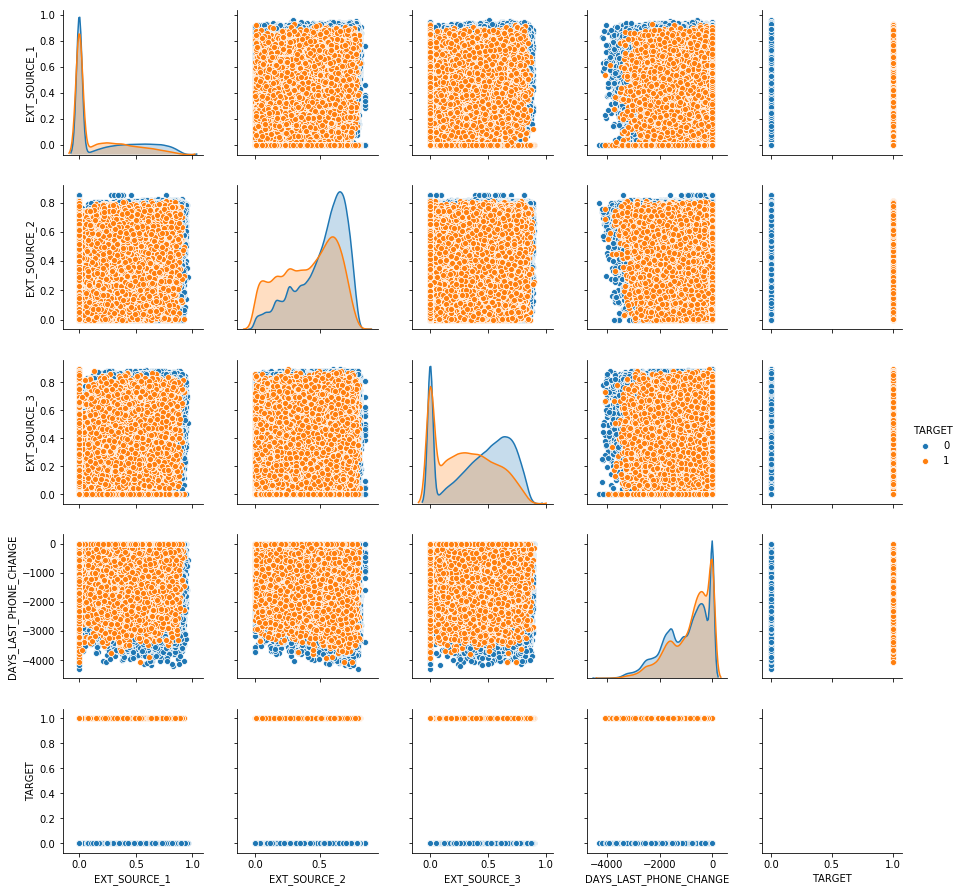

In [15]:
sns.pairplot(pd.concat([X_EX, y], axis=1), hue="TARGET");

#### テストデータの生成

In [0]:
X_test = df_test.select_dtypes(include=["int", "float"]).loc[:, features].fillna(0)

In [17]:
X_test.head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE
0,0.752614,0.789654,0.159520,-1740.0
1,0.564990,0.291656,0.432962,0.0
2,0.000000,0.699787,0.610991,-856.0
3,0.525734,0.509677,0.612704,-1805.0
4,0.202145,0.425687,0.000000,-821.0


#### 学習用データ、検証用データの作成

In [0]:
# ２割を検証用に用いる
X_train, X_val, y_train, y_val = train_test_split(X_EX, y, test_size=0.2)

#### 標準化

In [0]:
ss = StandardScaler()

In [20]:
ss.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
X_train = ss.transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

### パイプラインの作成

#### インスタンス

In [0]:
# ロジスティック回帰
LR = ("Logistic Classifier", LogisticRegression(penalty="l2", dual=False, tol=0.0001,
                                           C=1.0, fit_intercept=True))

In [0]:
# サポートベクターマシン
SVM = ("SVM", SVC(C=1.0, kernel="linear", degree=3, gamma="auto_deprecated",
                              coef0=0.0, shrinking=True, probability=False, tol=0.001,
                              cache_size=200, class_weight=None, verbose=False, 
                              max_iter=-1, decision_function_shape="ovr", 
                              random_state=None))

In [0]:
# 決定木
DT = ("Decision Tree", DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=None,
                                                   min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                                   max_features=None, random_state=None, max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0, min_impurity_split=None,
                                                   class_weight=None, presort=False))

In [0]:
classifiers = [LR]

#### パイプライン化

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier's name :  Logistic Classifier
accuracy : 0.65
precision : 0.14
recall : 0.63
f値 : 0.22


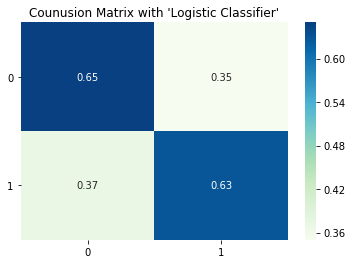

In [26]:
for classifier in tqdm(classifiers):
    name = classifier[0]
    clf = classifier[1]
    
    # オーバーサンプリング（不均衡の是正）
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    
    clf.fit(X_resampled, y_resampled) 
    y_pred = clf.predict(X_val)
    
    print("Classifier's name : ", name)
    print("=============")
    print('accuracy : {}'.format(np.round(metrics.accuracy_score(y_val, y_pred), 2)))
    print('precision : {}'.format(np.round(metrics.precision_score(y_val, y_pred), 2)))
    print('recall : {}'.format(np.round(metrics.recall_score(y_val, y_pred), 2)))
    print('f値 : {}'.format(np.round(metrics.f1_score(y_val, y_pred), 2)))
    print("=============")
    # 混同行列
    cmx = pd.DataFrame(metrics.confusion_matrix(y_val, y_pred))
    
    cmx = cmx.apply(lambda x:round(x/sum(x), 2), axis=1)
    
    sns.heatmap(cmx, cmap="GnBu", annot=True)
    plt.title("Counusion Matrix with '{}'".format(name))
    plt.yticks(rotation=0)
    plt.show()

In [0]:
#テストデータを予測する
submission = clf.predict_proba(X_test)[:,1]

#提出用にデータフレーム化
submission = pd.DataFrame({'SK_ID_CURR':df_test.SK_ID_CURR,'TARGET':submission})

#CSVに出力
submission.to_csv('first_sub.csv', index = False)

- スコア（auc）は0.67955となった。

### 【問題2】指標値の関数作成

このコンペティションでは提出した確率から指標値 AUC が計算され、それで順位が決まる。（Evaluationのページ参照）

- Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

 https://oku.edu.mie-u.ac.jp/~okumura/stat/ROC.html

 http://www.randpy.tokyo/entry/roc_auc

このAUCを計算する関数を作成すること。

#### AUCとは？

- False Positive Rate（FPR：偽陽性率）を横軸にTrue Positive Rate（TPR：真陽性率）を縦軸に置いてプロットしたものをROC曲線（Receiver Operating Characteristic Curve）という。

- AUCとは、ROC曲線とx軸、y軸で囲まれた範囲の面積を表し、値域は[0, 1]である。

- FPR = FP / (FP + TN) : 真の値はNegativeだが、誤まってPositiveと判定したサンプルの割合

- TPR = TP / (TP + FN)：真の値はPositiveだが、誤まってNegativeと判定したサンプルの割合

In [0]:
def evaluation(model, X, y):
    """
    訓練済のmodelとX,yを入力し、ROC曲線の可視化、aucの算出を行う関数
    
    Parameters
    ----------------
    model: 学習済みmodel
    X : ndarrary 説明変数
    y : ndarrary 目的変数 
    
    Returns
    ----------------
    auc
    スコア
    """
    #予測
    pred = model.predict_proba(X)
    
    #fpr,tpr,thressholdsを作成
    fpr, tpr, thresholds = metrics.roc_curve(y, pred[:,1])
    
    #aucを算出
    auc = metrics.auc(fpr, tpr)

    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True) 
    plt.show()

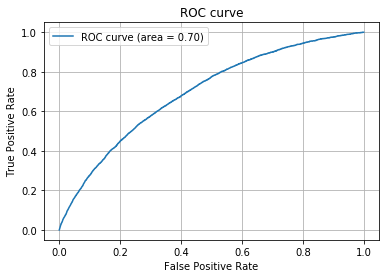

In [29]:
evaluation(clf, X_val, y_val)

### 【問題3】前処理・Feature Engineering・学習

精度を上げるために前処理・Feature Engineeringを行う。

そしてその特徴量によって学習、検証、再び前処理の流れを繰り返す。（この工程はEDAの続きとも言える）

Week3で学んだことを思い出しながら進めること。

#### EDAで実行したとおり、欠損値をドロップする。

In [0]:
# データの読み込み
df_train = pd.read_csv("application_train.csv")
df_test = pd.read_csv("application_test.csv")

In [0]:
# 説明変数として、int型及びfloat型のデータを抽出する
X = df_train.select_dtypes(include=["int", "float"])

In [0]:
# 説明変数としてEXT_SOURCE1,2,3、及び"DAYS_LAST_PHONE_CHANGE"を抽出
features = ["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3", "DAYS_LAST_PHONE_CHANGE", "TARGET"]

In [0]:
# 説明変数としてEXT_SOURCEを抽出
X_EX = X.loc[:, features]

In [0]:
# Week3のEDAの通り、欠損値は0で補間せずにドロップする。
X_EX = X_EX.dropna()

In [0]:
y = X_EX.TARGET

In [0]:
X_EX = X_EX[["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3", "DAYS_LAST_PHONE_CHANGE"]]

In [0]:
# ２割を検証用に用いる
X_train, X_val, y_train, y_val = train_test_split(X_EX, y, test_size=0.2)

In [0]:
features = ["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3", "DAYS_LAST_PHONE_CHANGE"]

In [0]:
X_test = df_test.select_dtypes(include=["int", "float"]).loc[:, features].fillna(0)

In [40]:
X_test.head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE
0,0.752614,0.789654,0.159520,-1740.0
1,0.564990,0.291656,0.432962,0.0
2,0.000000,0.699787,0.610991,-856.0
3,0.525734,0.509677,0.612704,-1805.0
4,0.202145,0.425687,0.000000,-821.0


In [0]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier's name :  Logistic Classifier
accuracy : 0.68
precision : 0.14
recall : 0.67
f値 : 0.24


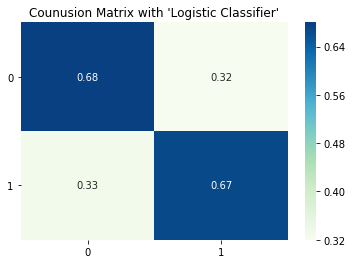

In [42]:
for classifier in tqdm(classifiers):
    name = classifier[0]
    clf = classifier[1]
    
    # オーバーサンプリング（不均衡の是正）
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    
    clf.fit(X_resampled, y_resampled) 
    y_pred = clf.predict(X_val)
    
    print("Classifier's name : ", name)
    print("=============")
    print('accuracy : {}'.format(np.round(metrics.accuracy_score(y_val, y_pred), 2)))
    print('precision : {}'.format(np.round(metrics.precision_score(y_val, y_pred), 2)))
    print('recall : {}'.format(np.round(metrics.recall_score(y_val, y_pred), 2)))
    print('f値 : {}'.format(np.round(metrics.f1_score(y_val, y_pred), 2)))
    print("=============")
    # 混同行列
    cmx = pd.DataFrame(metrics.confusion_matrix(y_val, y_pred))
    
    cmx = cmx.apply(lambda x:round(x/sum(x), 2), axis=1)
    
    sns.heatmap(cmx, cmap="GnBu", annot=True)
    plt.title("Counusion Matrix with '{}'".format(name))
    plt.yticks(rotation=0)
    plt.show()

In [0]:
#テストデータを予測する
submission = clf.predict_proba(X_test)[:,1]

#提出用にデータフレーム化
submission = pd.DataFrame({'SK_ID_CURR':df_test.SK_ID_CURR,'TARGET':submission})

#CSVに出力
submission.to_csv('second_sub.csv', index = False)

aucは0.67335と若干低下してしまった。

### Take away

- パイプラインの作成、EDAを踏まえた特徴量の再計算、モデルの再構築が重要であると学んだ。